<a href="https://colab.research.google.com/github/sanjeev4427/flower_classification/blob/main/17flowers_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 steps to identify your favourite flower using AI 

### Assemble your tools

Are you excited to go on a hiking trail to identify your favourite flower? Lets assemble our digital tools. We will buiild a Deep Learning algorithm called Convolutional Neural Network using PyTorch. 
What is PyTorch? 
PyTorch is a python library which makes it easier to develop AI algorithm. These are the five major steps:


*   Data (pictures of your favourite flowers)
*   Data transformation

*   Building model 
*   Training model
*   Making predictions

# Set up device
It is recommended to use google colab for this project. This is the fastest way to start as it already have all the necessary libraries installed. Follow this link to learn more https://colab.research.google.com/. We will be using the free GPU resources of colab so change your runtime to GPU. If are are using your own computer then install PyTorch by uncommenting the following line of codes.

In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

# Get your data
Now you have option to click your own pictures of flowers and seperate them nicely into folders or to save time download ready to use datasets from the following link. If you are using colab the run the following code block to downlod the data. This requires you to set up your account on kaggle. Follow this link to know more. https://www.kaggle.com/general/74235 

In [ ]:
# # how to dowload datasets from kaggle
# dataset_url = 'https://www.kaggle.com/general/156610'

In [ ]:
# from google.colab import files

# # files.upload() #this will prompt you to upload the kaggle.json
# !ls -lha kaggle.json # make sure kaggle.json file is present
# #Install kaggle API client
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# # dowloading data from kaggle
# # !kaggle datasets download -d datajameson/oxford-17-flowers-dataset 
# !unzip /content/gdrive/MyDrive/Mydata/oxford-17-flowers-dataset.zip -d /content/gdrive/MyDrive/Mydata/dataflowers/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import necessary libraries.

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import torch.nn as nn
import torch.nn.functional as F
# from torchvision.transforms import ToTensor
# import torchvision.transforms.functional as fn

Let us see the different type of flowers (called classes) in our datasets.

In [ ]:
data_dir = '/content/gdrive/MyDrive/Mydata/dataflowers/Oxford 17 Flowers'
classes = os.listdir(data_dir)
print(classes)

['Bluebell', 'Buttercup', 'Coltsfoot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'Lilyvalley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'Tulip', 'Windflower']


In [ ]:
# function for number of images of each class
def each_class_data(data_dir):
    classes = os.listdir(data_dir)
    label_list = [0]*len(classes)
    dataset = ImageFolder(data_dir)
    
    for i in range(len(dataset)):
      _,label = dataset[i]
      label_list[label] += 1
    [print(f'Number of {classes[i]} pictures: {val}') for i,val in enumerate(label_list)]

In [ ]:
# printing number of images of each class 
each_class_data(data_dir)



Number of Bluebell pictures: 80
Number of Buttercup pictures: 80
Number of Coltsfoot pictures: 80
Number of Cowslip pictures: 80
Number of Crocus pictures: 80
Number of Daffodil pictures: 80
Number of Daisy pictures: 80
Number of Dandelion pictures: 80
Number of Fritillary pictures: 80
Number of Iris pictures: 80
Number of Lilyvalley pictures: 80
Number of Pansy pictures: 80
Number of Snowdrop pictures: 80
Number of Sunflower pictures: 80
Number of Tigerlily pictures: 80
Number of Tulip pictures: 80
Number of Windflower pictures: 80


Let us see some examples of our flower images. 

In [ ]:
def show_example(img, label):
    dataset_img = ImageFolder(data_dir)
    print('Label: ', dataset_img.classes[label], "("+str(label)+")")
    plt.imshow(img)
    print(img.size)

# show_example(*dataset_img[24])

# Data transformation 

Next step is to transform the data in a way that it is easier to train and is more general. These are the data transformation steps used:
* Resizing 
* Normalising 
* Horizontal flip
* Cropping 
* Converting to tensor

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # how to get these values
dataset_tfms = tt.Compose([tt.Resize(size=(32,32)),
                         tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                        #  tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
                         
# valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

#applying data transformation 
dataset = ImageFolder(data_dir, dataset_tfms)

Splitting up data into training set, validation set and test set. 
1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set and test set, we can set aside 20 percent of the dataset to be used as the validation set and 10 percent of dataset as test set remaining 70 percent will be training set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
#splitting data into train, valid, test data
def data_split(dataset):
  train_size = int(0.7*len(dataset))
  valid_size = int(0.2*len(dataset))
  test_size = len(dataset) - (train_size + valid_size)
  
  train_dataset, valid_dataset, test_dataset = random_split(dataset,[train_size, valid_size, test_size])
  # train_dataset, valid_dataset = random_split(train_valid_dataset, [train_size, valid_size])
  return train_dataset, valid_dataset, test_dataset
train_ds, val_ds, test_ds = data_split(dataset)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

951 272 137


In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(15, 15))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
#         break

In [ ]:
# show_batch(train_dl)

# Model definition 

Third major step is to define our model. Let us define a CNN model. We will start with a base class in which function related to calculating accuracy, saving loss values, number of epochs are saved.   

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We will make a CNN model named 'flowers17CnnModel()' which extends the ImageClassificationBase class to define model architechture.
We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture. We will form 6 convulational layers and 3 linear layers for our model.

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class flowers17ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
        

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [ ]:
model = flowers17ResNet9(in_channels = 3, num_classes = 17)
model;

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

flower_resnet = to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [ ]:
history = [evaluate(model, val_dl)]

{'val_loss': 2.8410706520080566, 'val_acc': 0.03125}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 17 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. 

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using `jovian.log_hyperparams`.

In [ ]:
# # # jovian.reset()
# jovian.log_hyperparams({
#     'arch': arch,
#     'num_epochs': num_epochs,
#     'opt_func': opt_func.__name__,
#     'batch_size': batch_size,
#     'lr': lr,
# })

In [ ]:
# log_dict = {
#     'arch': arch,
#     'num_epochs': num_epochs,
#     'opt_func': 'opt_func.__name__',
#     'batch_size': 'batch_size',
#     'lr': lr,
# }

In [ ]:
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
model;

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 2.3898, val_loss: 2.8641, val_acc: 0.3438
Epoch [1], train_loss: 1.6009, val_loss: 3.7926, val_acc: 0.3313
Epoch [2], train_loss: 1.5818, val_loss: 3.9080, val_acc: 0.3438
Epoch [3], train_loss: 1.5940, val_loss: 4.3538, val_acc: 0.3250
Epoch [4], train_loss: 1.7653, val_loss: 5.9834, val_acc: 0.2531
Epoch [5], train_loss: 1.7412, val_loss: 7.2491, val_acc: 0.2313
Epoch [6], train_loss: 1.9415, val_loss: 2.4639, val_acc: 0.4750
Epoch [7], train_loss: 1.7179, val_loss: 2.4951, val_acc: 0.4187
Epoch [8], train_loss: 1.5437, val_loss: 1.9638, val_acc: 0.4781
Epoch [9], train_loss: 1.6619, val_loss: 2.1295, val_acc: 0.4969
Epoch [10], train_loss: 1.4488, val_loss: 1.4156, val_acc: 0.5938
Epoch [11], train_loss: 0.9365, val_loss: 1.2688, val_acc: 0.6250
Epoch [12], train_loss: 0.9901, val_loss: 1.2862, val_acc: 0.6469
Epoch [13], train_loss: 0.8793, val_loss: 1.3977, val_acc: 0.6281
Epoch [14], train_loss: 0.8721, val_loss: 1.4173, val_acc: 0.6531
Epoch [15], train_lo

In [ ]:
# jovian.log_metrics(train_loss=history[-1]['train_loss'], 
#                    val_loss=history[-1]['val_loss'], 
#                    val_acc=history[-1]['val_acc'])

We can also plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

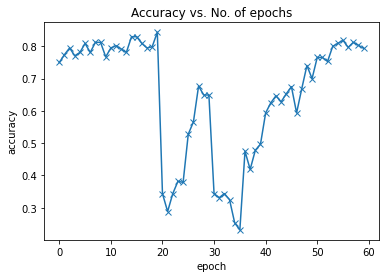

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

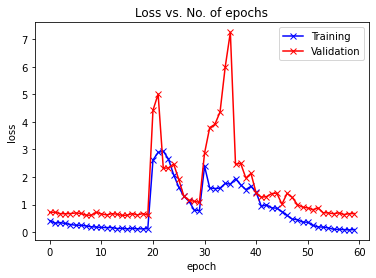

In [ ]:
plot_losses(history)